In [1]:
%matplotlib inline
from IPython.display import clear_output
import time
from Environments.environments import train_envs, get_all_avail_envs, get_all_avail_test_envs, test_envs
from Agents.dqn_agent import DQN_Agent
from Agents.ppo_agent import PPO_Agent
from Models import fc, rnn
import matplotlib.pyplot as plt
import utils
from Curriculum_managers.random_curriculum import Random_Curriculum
from Curriculum_managers.paired_curriculum import PAIRED_Curriculum
from Curriculum_managers.paired_curriculum_or import PAIRED_Curriculum_OR
# from Curriculum_managers.paired_curriculum_hf import PAIRED_Curriculum_History_filter
# from Curriculum_managers.paired_curriculum_hfe import PAIRED_Curriculum_History_filter_Entropy
from Curriculum_managers.repaired_curriculum import REPAIRED_Curriculum
from Curriculum_managers.climb import CLIMB
from Curriculum_managers.curriculum_no_regulator_he import Curriculum_Unregulated_Entropy_History

import plotly.express as px
import numpy as np
import plotly.io as pio
import cv2
pio.renderers.default = "browser"


In [2]:
def plot_res(vec, title):
    fig = px.line(x=range(len(np.convolve(vec, np.ones(100)/100,mode='valid'))), y=np.convolve(vec, np.ones(100)/100, mode='valid'), title=title)
    fig.show()

In [3]:
device = utils.init_torch()
env_names = get_all_avail_envs()
print(env_names[:15])


['SingleTaxiEnv', 'FrozenLakeEnv', 'AdversarialEnv', 'ReparameterizedAdversarialEnv', 'MiniAdversarialEnv', 'MiniReparameterizedAdversarialEnv', 'NoisyAdversarialEnv', 'MediumAdversarialEnv', 'GoalLastAdversarialEnv', 'MiniGoalLastAdversarialEnv', 'Sokoban']


define n_iters

In [4]:
n_iters = 50000

In [5]:
env = train_envs['FrozenLakeEnv'](n_clutter=10)
n_actions = env.get_action_space().n
obs_shape = env.get_observation_space()
gen_obs_shape = env.get_generator_observation_space()
gen_action_dim = env.get_generator_action_space().n

In [7]:
env.init_from_vec([10,1,2,3,4,5,6,7,8,9, 10])

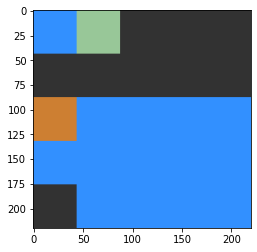

In [8]:
plt.imshow(env.render('rgb_array'))

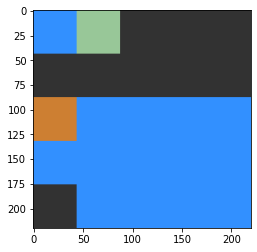

In [9]:
env.step(0)
plt.imshow(env.render('rgb_array'))

# RANDOM CURRICULUM

In [ ]:
r_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5,num_parallel_envs=4, lr=0.0001, model=rnn.RNN)
r_teacher = Random_Curriculum(env ,trainee=r_agent)
r_rewards = r_teacher.teach(n_iters=n_iters, n_episodes=1)

# PAIRED CURRICULUM

In [ ]:
p_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
p_teacher = PAIRED_Curriculum(env, teacher_agent=teacher_agent ,trainee=p_agent)
p_rewards = p_teacher.teach(n_iters=200, n_episodes=1)

# PAIRED CURRICULUM OR

In [7]:
por_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
por_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
por_teacher = PAIRED_Curriculum_OR(env, teacher_agent=por_teacher_agent ,trainee=por_agent)
por_rewards = por_teacher.teach(n_iters=200, n_episodes=1)

no files to load from


R:000000.0, entropy: 1.386: 100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


# REPAIRED

In [6]:
phf_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
phf_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
phf_teacher = REPAIRED_Curriculum(env, teacher_agent=phf_teacher_agent ,trainee=phf_agent)
phf_rewards = phf_teacher.teach(n_iters=n_iters, n_episodes=1)

no files to load from


  0%|          | 0/50000 [00:00<?, ?it/s]


IndexError: list index out of range

In [12]:
phf_teacher.set_agents_to_train_mode()

In [13]:
phf_teacher.trainee.store_values

True

In [14]:
phf_rewards = phf_teacher.teach(n_iters=n_iters, n_episodes=1)

  0%|          | 0/50000 [00:00<?, ?it/s]


TypeError: 'type' object is not iterable

# PAIRED History Filter Entropy

In [ ]:
# phfe_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
# phfe_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
# phfe_teacher = PAIRED_Curriculum_History_filter_Entropy(env, teacher_agent=phfe_teacher_agent ,trainee=phfe_agent)
# phfe_rewards = phfe_teacher.teach(n_iters=n_iters, n_episodes=1)

# CLIMB

In [6]:
phfe_or_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
phfe_or_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
phfe_or_teacher = CLIMB(env, teacher_agent=phfe_or_teacher_agent ,trainee=phfe_or_agent)
phfe_rewards = phfe_or_teacher.teach(n_iters=200, n_episodes=1)

no files to load from


R:000000.0, entropy: 1.38: 100%|██████████| 200/200 [02:52<00:00,  1.16it/s] 


# UNREGULATED ENTROPY HISTORY

In [10]:
pee_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pee_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5 ,lr=0.0001, model=rnn.RNN)
pee_teacher = Curriculum_Unregulated_Entropy_History(env, teacher_agent=pee_teacher_agent ,trainee=pee_agent, inv_reward_entropy_coeff=1)
pee_rewards = pee_teacher.teach(n_iters=250, n_episodes=1)

loading metadatafrom ./results/Curriculum_Unregulated_Entropy_History/FrozenLakeEnv/meta_data.pkl
loading models from last iter: 199


R:000000.0, entropy: 1.382: 100%|██████████| 51/51 [00:05<00:00,  8.84it/s]


In [ ]:
env = pee_teacher.create_envs(1)[0]
plt.imshow(env.render('rgb_array'))

# RESULTS CHECK

In [ ]:
env.reset_random()
plt.imshow(env.render('rgb_array'))

In [144]:
domain_name = "Maze"
difficulty = "easy"
get_all_avail_test_envs(domain_name, difficulty)

['Cluttered1MinigridMini',
 'Cluttered6MinigridMini',
 'Cluttered7MinigridMini',
 'EmptyRandomEnv6x6Minigrid',
 'EmptyRandomEnv15x15Minigrid',
 'MiniTwoRoomsEnvMinigrid']

In [159]:
env_name = "EmptyRandomEnv6x6Minigrid"

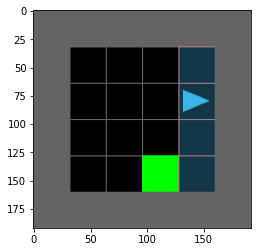

In [160]:
env = test_envs[domain_name][difficulty][env_name]()
plt.imshow(env.render('rgb_array'))

In [ ]:
#pen_agent, p_agent, r_agent, pee_agent

In [86]:
generic_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)

In [161]:
generic_agent.load_agent("./results/PAIRED_Curriculum/MiniAdversarialEnv/_49999_trainee.ckpt")

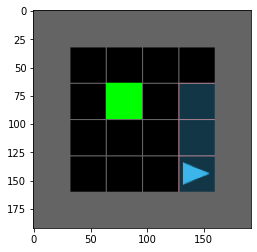

evaluation episode: 0 R: 0 72


In [162]:
env = test_envs[domain_name][difficulty][env_name]()
agent = generic_agent
agent.set_eval_mode()
vid = []
for i in range(1):
    obs = env.reset()
    # break
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        clear_output(wait=True)
        frame = env.render('rgb_array')
        # vid.append(frame)
        plt.imshow(frame)
        plt.show()
        # env.render(mode='rgb_array')
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        # print(action, r, done)

        R += r
        t += 1
        reset = t == 500
        time.sleep(0.01)

        if done or reset:
            break
print('evaluation episode:', i, 'R:', R, t)

In [ ]:
save_vid(vid,'test')

In [5]:
def save_vid(frames, vid_name):
    out = cv2.VideoWriter(vid_name+'.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (800,640))
 
    for i in range(len(frames)):
        frame = cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR)
        frame = cv2.resize(frame, (800,640))
        out.write(frame)
    out.release()

# Curriculum results

In [6]:
def run_agent(agent, env, num_iters=1, plot=False):
    agent.set_eval_mode()
    mean_r = 0
    for i in range(num_iters):
        obs = env.reset()
        # break
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            if plot:
                clear_output(wait=True)
                plt.imshow(env.render('rgb_array'))
                plt.show()
                time.sleep(0.01)

            # env.render(mode='rgb_array')
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)

            R += r
            t += 1
            reset = t == 500

            if done or reset:
                break
        mean_r +=R
    return mean_r / num_iters

In [ ]:
runable_envs = {}
for env_name in get_all_avail_test_envs():
    try:
        test_env = test_envs[env_name]()
        runable_envs[env_name] = test_env
    except:
        print("Exception",env_name, test_env.minigrid_mode)

In [ ]:
agents = {"paired_entropy": pen_agent, "paired":p_agent, "random":r_agent, "entropy_only":pee_agent, "entropy_history": peh_agent, "paired_entropy_history": penh_agent}

In [ ]:
def calc_result(agents, runable_envs):
    i=0
    all_results = np.zeros((len(runable_envs), len(agents)))
    for env_name,env in runable_envs.items():
        print(env_name, i, len(runable_envs))
        j= 0
        for a_name, a in agents.items():
            env.__init__()
            res = run_agent(a, env)
            all_results[i][j] = res
            j+=1
        i+=1
    return all_results

In [ ]:
agents = {"random":agent}

In [ ]:
all_results = calc_result(agents, runable_envs)

In [ ]:
clean_env_names = np.array(list(runable_envs.keys()))[~np.all(all_results == 0, axis=1)]
clean_res = all_results[~np.all(all_results == 0, axis=1)]

In [ ]:
plot_test_res_all(clean_res, clean_env_names, agents)

In [ ]:
print_mean_score(all_results, agents)

In [ ]:
def print_mean_score(all_results, agents):
    scores = np.mean(all_results, axis=0)
    for i,a in enumerate(agents):
        print(f"{a}_mean:", scores[i])

In [ ]:
from plotly.subplots import make_subplots
from plotly import graph_objects as go
def plot_test_res_all(data_array, env_names, agents_dict):
    color10_16 = ['violet', 'orange', 'cyan', "green",  "yellow"]
    col_len = int(np.sqrt(len(env_names)))
    row_len = (col_len + len(env_names) - col_len**2)
    fig = make_subplots(rows=row_len, cols=col_len, subplot_titles=env_names)
    for i,env_name in enumerate(env_names):
        fig.add_trace(
            go.Bar(
                name=env_name,
                x=list(agents_dict.keys()),
                y=data_array[i],
                marker_color=color10_16
            ),
            row=(i // col_len) +1 ,
            col =(i % col_len)+1,
            
        )
    fig.update_layout(height=1600, width=1600, title_text="Reward Comparation", showlegend=False, legend=dict(
    yanchor="bottom",
    y=-0.5,
    xanchor="right",
    x=1
))
    fig.show()